In [1]:
import numpy as np
import matplotlib as mpl
import pandas as pd
import os 
from matplotlib import pyplot as plt


In [156]:
nasa = pd.read_csv('/content/DailyDelhiClimateTrain.csv', index_col='date', parse_dates=True)
nasa.index.freq = 'D'

In [157]:
nasa.isna()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,False,False,False,False
2013-01-02,False,False,False,False
2013-01-03,False,False,False,False
2013-01-04,False,False,False,False
2013-01-05,False,False,False,False
...,...,...,...,...
2016-12-28,False,False,False,False
2016-12-29,False,False,False,False
2016-12-30,False,False,False,False


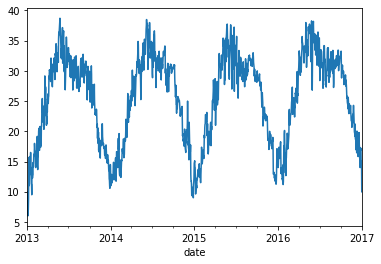

In [158]:
nasa['meantemp'].plot()

In [152]:
from statsmodels.tsa.seasonal import seasonal_decompose

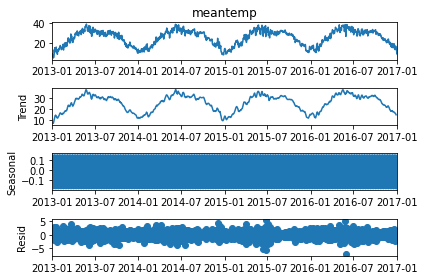

In [159]:
results = seasonal_decompose(nasa['meantemp'])
results.plot();

In [115]:
train = nasa.iloc[:1097]
test = nasa.iloc[1097:]

In [42]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [116]:
nasa.head(),nasa.tail()

(             meantemp
 date                 
 2013-01-01  10.000000
 2013-01-02   7.400000
 2013-01-03   7.166667
 2013-01-04   8.666667
 2013-01-05   6.000000,              meantemp
 date                 
 2016-12-28  17.217391
 2016-12-29  15.238095
 2016-12-30  14.095238
 2016-12-31  15.052632
 2017-01-01  10.000000)

In [117]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [118]:
scaled_train[:10]

array([[0.12227074],
       [0.04279476],
       [0.0356623 ],
       [0.08151383],
       [0.        ],
       [0.03056769],
       [0.03056769],
       [0.08733624],
       [0.24454148],
       [0.15283843]])

In [14]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [122]:
# define generator
n_input = 360
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [123]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.12227074 0.04279476 0.0356623  0.08151383 0.         0.03056769
 0.03056769 0.08733624 0.24454148 0.15283843 0.29694323 0.24454148
 0.30058224 0.20887918 0.26637555 0.23944687 0.3209607  0.23944687
 0.19868996 0.16157205 0.15895197 0.1069869  0.24454148 0.23944687
 0.19104803 0.20378457 0.20960699 0.27001456 0.24836245 0.26637555
 0.31179039 0.30567686 0.31441048 0.36681223 0.34934498 0.32478166
 0.32605531 0.29344978 0.24454148 0.28820961 0.28275109 0.3018559
 0.2852984  0.31441048 0.34643377 0.40247453 0.25764192 0.23435226
 0.29344978 0.30131004 0.3580786  0.4279476  0.44323144 0.34934498
 0.33187773 0.33242358 0.36244541 0.45240175 0.41048035 0.34643377
 0.39737991 0.40756914 0.35458515 0.45469432 0.45414847 0.53275109
 0.55531295 0.59388646 0.52401747 0.55021834 0.5349345  0.47379913
 0.4992722  0.55531295 0.43813683 0.50946143 0.53275109 0.50436681
 0.70815138 0.54512373 0.58842795 0.65338428 0.6419214  0.5349345
 0.55458515 0.45851528 0.50218341 0.46615721 0

In [124]:
X.shape

(1, 360, 1)

In [125]:
# We do the same thing, but now instead for 12 months
n_input = 30
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [19]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [126]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [127]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100)               40800     
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [128]:
model.fit(generator,epochs=5)

Epoch 1/5
1067/1067 [==============================] - 17s 15ms/step - loss: 0.0078
Epoch 2/5
1067/1067 [==============================] - 15s 14ms/step - loss: 0.0043
Epoch 3/5
1067/1067 [==============================] - 16s 15ms/step - loss: 0.0039
Epoch 4/5
1067/1067 [==============================] - 16s 15ms/step - loss: 0.0034
Epoch 5/5
1067/1067 [==============================] - 16s 15ms/step - loss: 0.0032


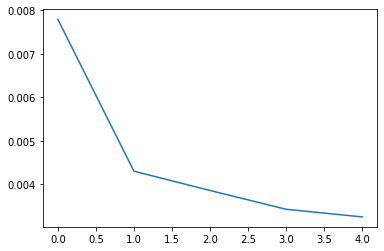

In [129]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [130]:
last_train_batch = scaled_train[-30:]

In [131]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [132]:
model.predict(last_train_batch)

array([[0.24678466]], dtype=float32)

In [133]:
scaled_test[0]

array([0.25600437])

In [134]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [136]:
test_predictions[0]

array([0.24678466], dtype=float32)

In [137]:
test.head()

,meantemp
date,
2016-01-03,14.375000
2016-01-04,15.750000
2016-01-05,15.833333
2016-01-06,17.375000
2016-01-07,17.125000


In [138]:
true_predictions = scaler.inverse_transform(test_predictions)

In [139]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [140]:
test.head()

,meantemp,Predictions
date,,
2016-01-03,14.375000,14.073384
2016-01-04,15.750000,13.875059
2016-01-05,15.833333,13.679515
2016-01-06,17.375000,13.492352
2016-01-07,17.125000,13.313072


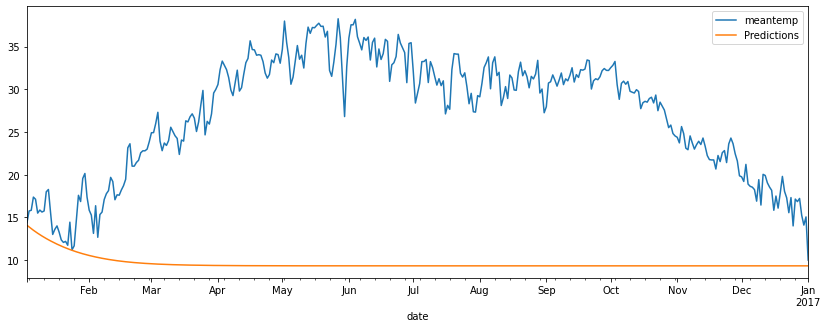

In [160]:
test.plot(figsize=(14,5))

In [142]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['meantemp'],test['Predictions']))
print(rmse)

19.00776558934131
